In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher

In [2]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)


In [3]:
# def save_new_agg(data, name):
#     data_temp = data[((data['PROVINCE']=='LIMA') & (data['STATE']=='LIMA')) |
#                      (data['STATE']=='CALLAO')]
#     data_temp = data_temp[data_temp['YEAR']==2020].reset_index(drop=True)
#     data_temp['SECTOR'] = data_temp['SECTOR'].apply(lambda x: x if x == 'PRIVADO' else 'PUBLICO')
#     columns_ = data_temp['SECTOR'].unique()
#     data_temp = data_temp.groupby(['UBIGEO', 'DISTRICT','SECTOR','CO_IPRESS']).agg({ 'QTY_PEOPLE_SERVED': "sum"}).reset_index()
#     data_temp = data_temp.groupby(['UBIGEO', 'DISTRICT','SECTOR']).agg({ 'CO_IPRESS': "count"}).reset_index()
#     data_temp = data_temp.pivot(index =['UBIGEO', 'DISTRICT'], columns ='SECTOR')
#     data_temp.columns = data_temp.columns.droplevel()
#     data_temp = data_temp.reset_index()
#     data_temp.fillna(0, inplace = True)

#     data_temp['TOTAL'] = data_temp[columns_].sum(axis=1)
#     data_temp.to_csv(name, index = False)
#     return data_temp

In [4]:
# paths = [
#     ['morbilidad_b2.csv', 'B2'],
#     ['morbilidad_c2.csv', 'C2'],
#     ['morbilidad_d2.csv', 'D2']]

# columns = [
#     'DATE',
#     'YEAR',
#     'MONTH',
#     'STATE',
#     'PROVINCE',
#     'DISTRICT',
#     'SECTOR',
#     'CATEGORY',
#     'NAME',
#     'SEX',
#     'AGE',
#     'DIAGNOSIS_ID',
#     'QTY_PEOPLE_SERVED',
#     'DISEASE',
#     'DISEASE_GROUP'
# ]

# all_data = pd.DataFrame()
# for file in paths:
#     data = pd.read_pickle('data/'+file[0])
#     data = data.filter(columns)
#     data['TYPE'] = file[1]
#     all_data = pd.concat([all_data, data])

# all_data.to_pickle('data/morbilidad_global.csv')  

In [5]:
all_data = pd.read_pickle('data/morbilidad_global.csv')
all_data['IS_LIMA'] = all_data['PROVINCE'].apply(lambda x : True if x=='LIMA' else False)

In [6]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,NAME,SEX,AGE,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,TYPE,IS_LIMA
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R10.2,10,PELVIC AND PERINEAL PAIN,ABDOMINAL AND PELVIC PAIN,B2,True
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R10.4,11,UNIDENTIFIED,ABDOMINAL AND PELVIC PAIN,B2,True
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R11.X,3,UNIDENTIFIED,NAUSEA AND VOMITING,B2,True
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R16.0,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","HEPATOMEGALY AND SPLENOMEGALY, NOT ELSEWHERE C...",B2,True
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R42.X,1,UNIDENTIFIED,DIZZINESS AND GIDDINESS,B2,True


In [7]:
data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()
data_temp.head()

,DATE,sum,count
0,2015-01-01,6370,1010
1,2015-02-01,4303,837
2,2015-03-01,12568,917
3,2015-04-01,14378,1178
4,2015-05-01,16432,1284


<ipython-input-8-6b5329c1e723>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


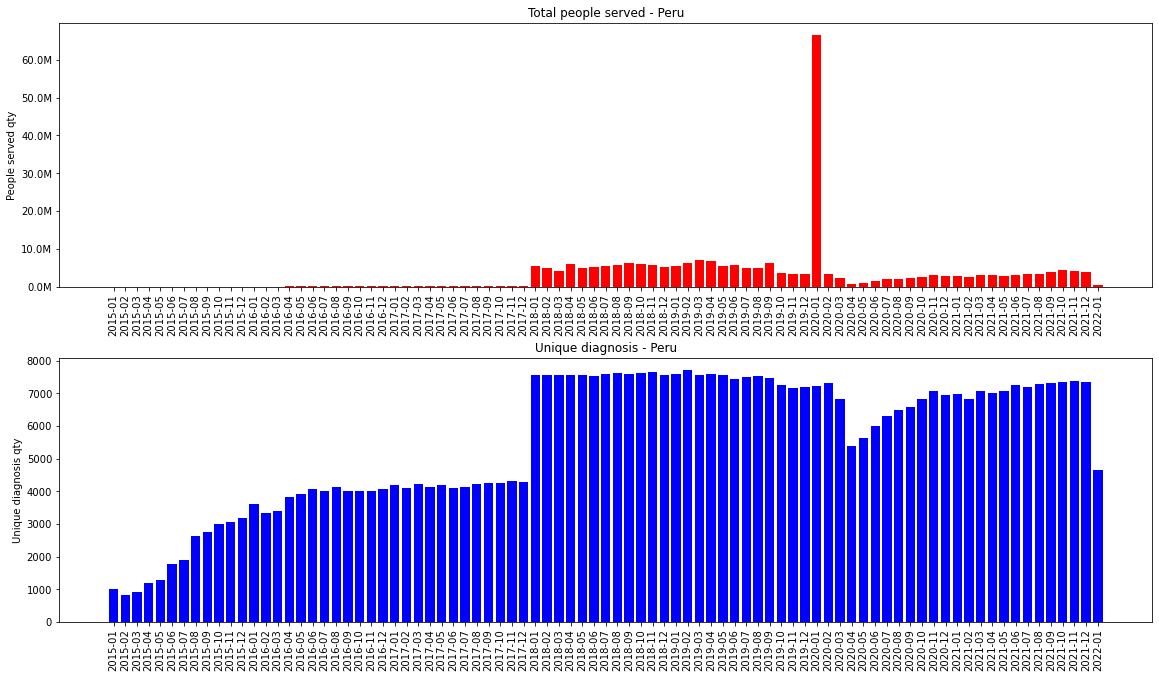

In [8]:
#fig, ax = plt.subplots(2, 1, figsize=(10,7))
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp['DATE'])]

y = list(data_temp['sum'])
ax[0].bar(x, y, color='red')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Peru')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp['count'])
ax[1].bar(x, y, color='blue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

In [9]:
### Top 5 diagnosis 

In [10]:
PARAMETER = 'DISEASE_GROUP'
data_temp = all_data[all_data['YEAR']>=2018]

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

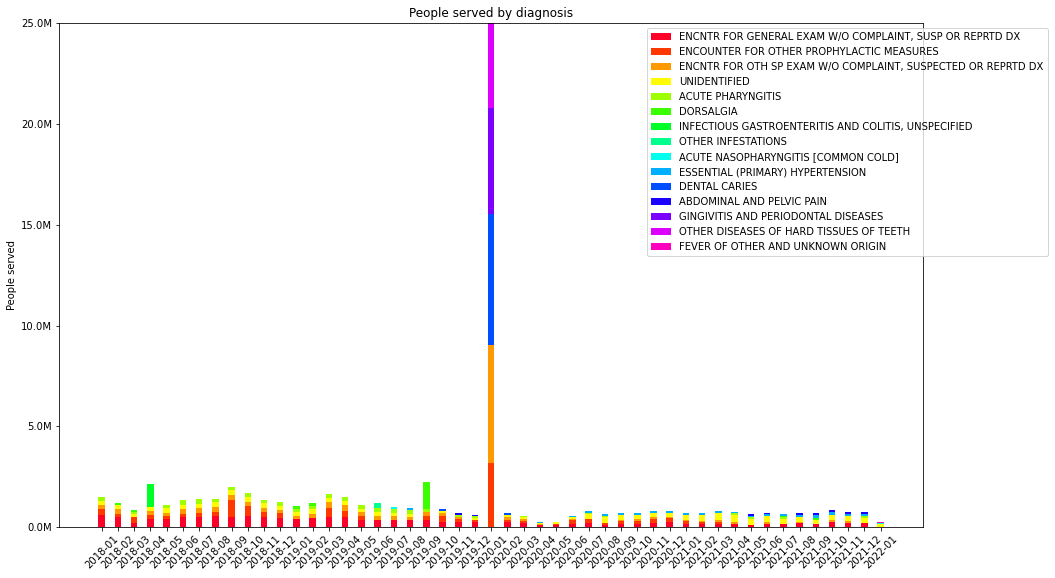

In [11]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

In [12]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,NAME,SEX,AGE,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,TYPE,IS_LIMA
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R10.2,10,PELVIC AND PERINEAL PAIN,ABDOMINAL AND PELVIC PAIN,B2,True
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R10.4,11,UNIDENTIFIED,ABDOMINAL AND PELVIC PAIN,B2,True
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R11.X,3,UNIDENTIFIED,NAUSEA AND VOMITING,B2,True
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R16.0,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","HEPATOMEGALY AND SPLENOMEGALY, NOT ELSEWHERE C...",B2,True
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R42.X,1,UNIDENTIFIED,DIZZINESS AND GIDDINESS,B2,True


### Lima and Peru

In [13]:
PARAMETER = 'IS_LIMA'
data_temp = all_data[all_data['YEAR']>=2018]

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

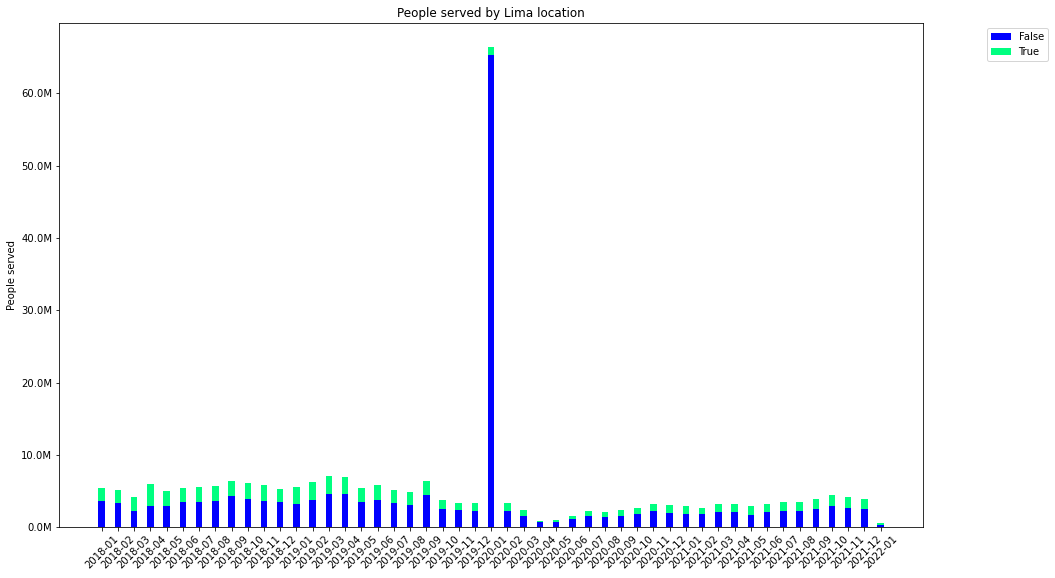

In [14]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "winter"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by Lima location')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

<AxesSubplot:xlabel='YEAR'>

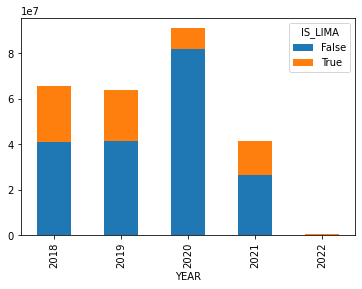

In [15]:
# PARAMETER = 'IS_LIMA'
data_temp = all_data[all_data['YEAR']>=2018]


#data_temp = data_temp.groupby(['YEAR','CATEGORY_GROUP','CANCER']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp = data_temp.groupby(['YEAR', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': 'sum'})
data_temp = data_temp.sort_values(by=['YEAR', PARAMETER]).reset_index()
data_temp = data_temp.pivot(index =['YEAR'], columns = PARAMETER)
data_temp.columns = data_temp.columns.droplevel()
# data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)

data_temp.head()
data_temp.plot(kind="bar", stacked=True)

### Births in Lima

In [16]:
PARAMETER = 'BIRTHS'
data_temp = all_data[all_data['YEAR']>=2018]

data_temp['BIRTHS'] = data_temp['DISEASE_GROUP'].apply(lambda x : True if 'CHILDBIRTH' in str(x) else False)

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

<ipython-input-16-8243073e0ac1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['BIRTHS'] = data_temp['DISEASE_GROUP'].apply(lambda x : True if 'CHILDBIRTH' in str(x) else False)


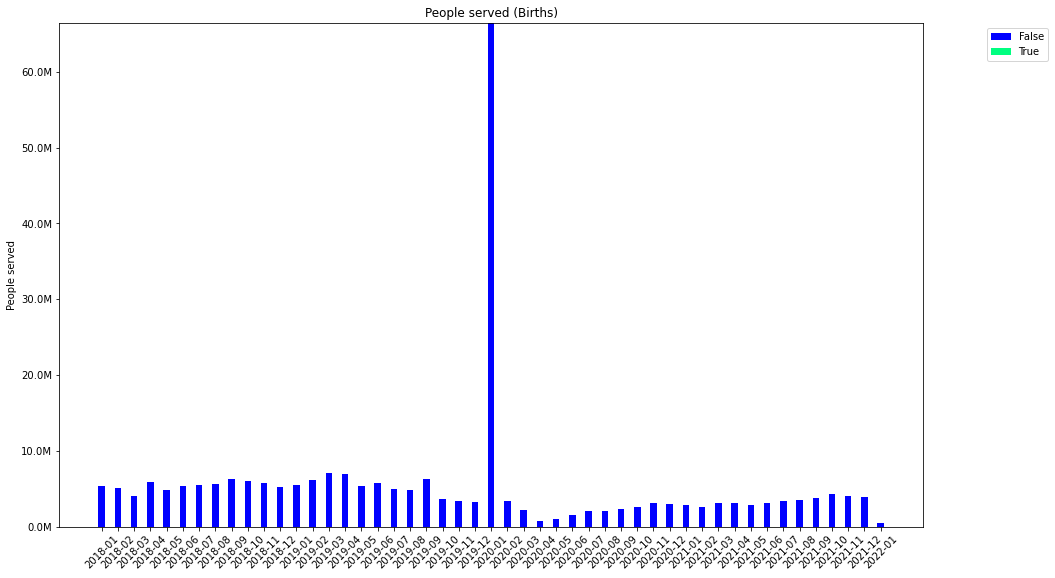

In [17]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "winter"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Births)')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

### Services type in Lima

In [18]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,NAME,SEX,AGE,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,TYPE,IS_LIMA
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R10.2,10,PELVIC AND PERINEAL PAIN,ABDOMINAL AND PELVIC PAIN,B2,True
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R10.4,11,UNIDENTIFIED,ABDOMINAL AND PELVIC PAIN,B2,True
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R11.X,3,UNIDENTIFIED,NAUSEA AND VOMITING,B2,True
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R16.0,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","HEPATOMEGALY AND SPLENOMEGALY, NOT ELSEWHERE C...",B2,True
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,CLÍNICA INTERNACIONAL,2,7,R42.X,1,UNIDENTIFIED,DIZZINESS AND GIDDINESS,B2,True


In [19]:
all_data[0tyeop]

SyntaxError: invalid syntax (<ipython-input-19-ab15df87743b>, line 1)

In [ ]:
PARAMETER = 'BIRTHS'
data_temp = all_data[all_data['YEAR']>=2018]
data_temp = data_temp[data_temp['IS_LIMA']==True]

data_temp['BIRTHS'] = data_temp['DISEASE_GROUP'].apply(lambda x : True if 'CHILDBIRTH' in str(x) else False)

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)